[INFO] Filtered out 24 samples due to invalid runtimeMs
[STAT] queries=240  median_K=6.0  max_K=6
[STAT] near-tie groups (<3% gap): 131/240 = 54.6%


C:\Users\huyue\anaconda3\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'nn.glob.GlobalAttention' is deprecated, use 'nn.aggr.AttentionalAggregation' instead
  warnings.warn(out)


Using GNN (RGCN) with 6 edge types. Attention
[TEST-SEL] Top-1=2.8%  Regret(median)=1.23×  Regret(mean)=1.34×  over 36 queries
[TEST-SEL] Success@10%=25.0%  Success@20%=41.7%  Success@30%=55.6%
[TEST-SEL+] Top-3=80.6%  Top-5=97.2%  NDCG@3=0.896  NDCG@5=0.933
[TEST-SEL+] Spearman=-0.153  PairAcc(macro)=0.440  PairAcc(micro)=0.499
[TEST-SEL+] Best-rank: mean=2.86  median=2.50
[TEST-SEL+] Regret percentiles: P75=1.39×  P90=1.74×  P95=2.21×  P99=2.45×  TrimMean@90%=1.24×
[TEST-SEL+] Calibration (log): MAE=0.558  RMSE=0.690  Inference/batch≈38.75 ms
[RANK] epoch 01 rank_loss=0.1261 | val_Regret(median)=1.226×  Top-1=2.8%
[TEST-SEL] Top-1=2.8%  Regret(median)=1.23×  Regret(mean)=1.34×  over 36 queries
[TEST-SEL] Success@10%=25.0%  Success@20%=41.7%  Success@30%=55.6%
[TEST-SEL+] Top-3=77.8%  Top-5=97.2%  NDCG@3=0.895  NDCG@5=0.932
[TEST-SEL+] Spearman=-0.163  PairAcc(macro)=0.434  PairAcc(micro)=0.492
[TEST-SEL+] Best-rank: mean=2.89  median=2.50
[TEST-SEL+] Regret percentiles: P75=1.39×  P9

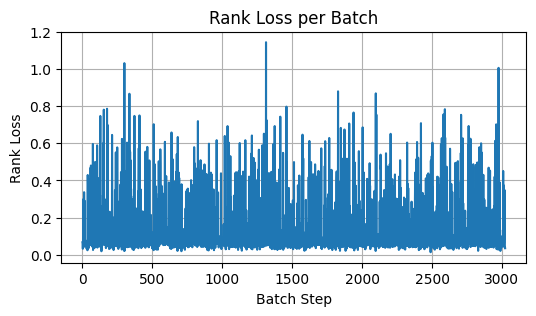

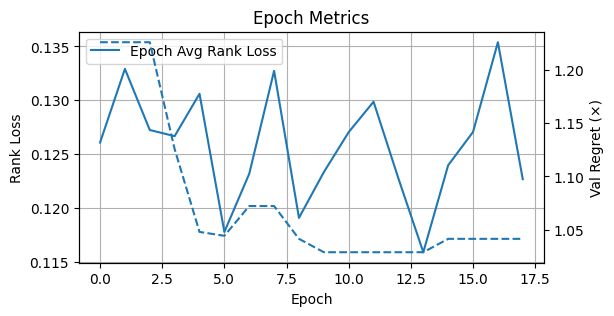

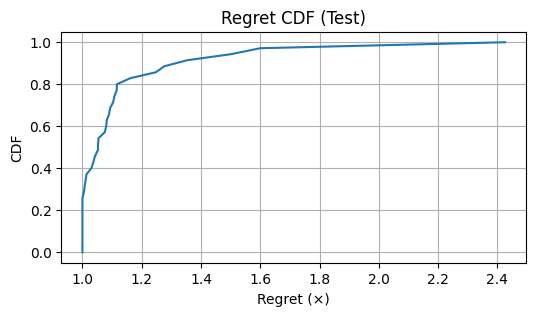

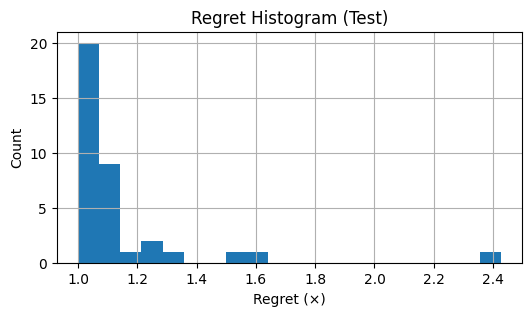

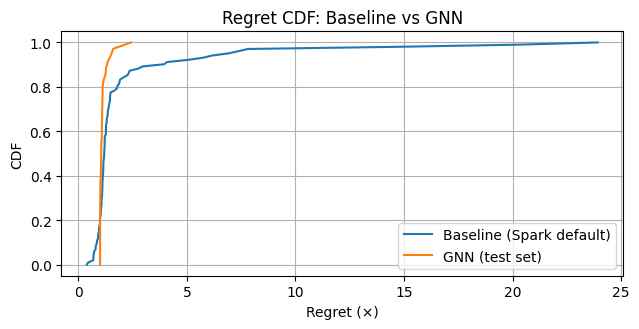

C:\Users\huyue\AppData\Local\Temp\ipykernel_67012\3888421349.py:805: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showmeans=True)


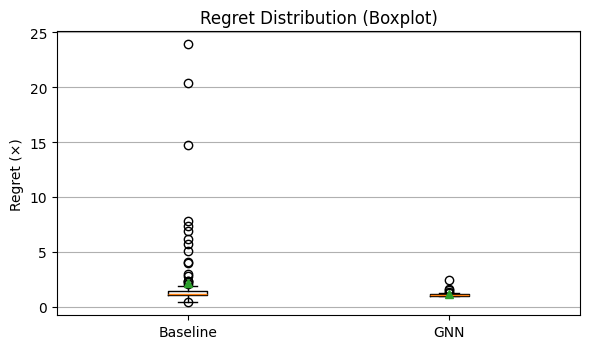

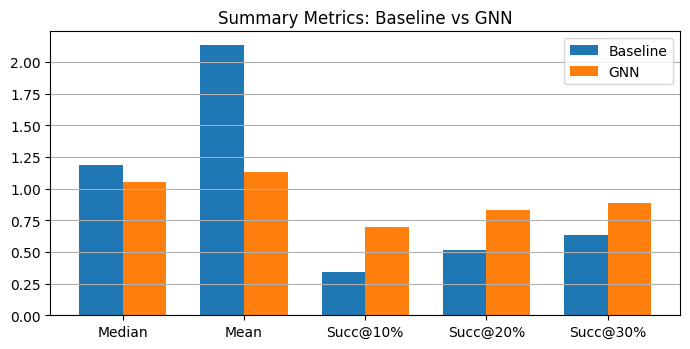

Saved comparison to "eval/cdf_baseline_vs_gnn.png", "eval/boxplot_baseline_vs_gnn.png", "eval/bars_baseline_vs_gnn.png", and "eval/compare_baseline_vs_gnn.json".
Saved eval to "eval/eval_report.json" and "eval/regrets_per_query.csv".


In [2]:
import os, json, glob, math, random, re, time, csv
from collections import defaultdict, Counter
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Sampler

USE_SCHEME     = True   
USE_NPARTS     = True   
USE_ATTENTION  = True    
USE_GNN        = True    

CALIB_REG_WEIGHT = 0.10


def set_seeds(seed: int = 2025):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

try:
    from torch_geometric.data import Data as GeomData
    from torch_geometric.nn import (
        global_mean_pool as pyg_global_mean_pool,
        RGCNConv,
        GlobalAttention,
    )
    PYG = True
except Exception:
    PYG = False
    class GeomData: ...
    def pyg_global_mean_pool(x, batch):
        nb = int(batch.max().item()) + 1 if batch.numel() > 0 else 1
        g = torch.zeros((nb, x.size(1)), dtype=x.dtype, device=x.device)
        g.index_add_(0, batch, x)
        counts = torch.bincount(batch, minlength=nb).clamp(min=1).unsqueeze(1)
        return g / counts

def log1p(x): return math.log1p(max(0.0, float(x)))
def to_idx(s, vocab, unk_idx): return vocab.get(s, unk_idx)

def build_vocab(values, min_freq=1, max_size=None, add_unk=True):
    cnt = Counter(values)
    items = [k for k,v in cnt.items() if v >= min_freq]
    items.sort(key=lambda k: (-cnt[k], k))
    if max_size: items = items[:max_size]
    itos = []
    if add_unk: itos.append("<unk>")
    itos += items
    stoi = {s:i for i,s in enumerate(itos)}
    return stoi, itos

PART_SCHEME_RE = re.compile(r'([A-Za-z]+)Partitioning', re.I)
NPART_RE = re.compile(r',\s*(\d+)\)')

def parse_partitioning_fields(s: str):
    if not s: return "unknown", 0
    m = PART_SCHEME_RE.search(s); scheme = (m.group(1) if m else "unknown").lower()
    m2 = NPART_RE.search(s); nparts = int(m2.group(1)) if m2 else 0
    return scheme, nparts

def is_join_op(op_name: str) -> bool:
    return "join" in op_name.lower()

GRAPH_FEATS_DIM = 8
def extract_graph_num_feats(sample):
    nodes = sample.get("nodes", [])
    edges = sample.get("edges", [])
    n = len(nodes)
    if n == 0:
        return np.zeros((GRAPH_FEATS_DIM,), np.float32)

    joins = 0
    nparts_list = []
    col_cnt = 0
    codegen_any = 0
    max_order = 0
    outcols = []

    for nd in nodes:
        op = str(nd.get("op",""))
        joins += int(is_join_op(op))
        part_str = str(nd.get("partitioning",""))
        _, nparts = parse_partitioning_fields(part_str)
        nparts_list.append(max(0,int(nparts)))
        col_cnt += 1 if nd.get("supportsColumnar", False) else 0
        codegen_any |= int(op.lower().startswith("wholestagecodegen"))
        max_order = max(max_order, int(nd.get("orderingSize", 0)))
        outcols.append(float(nd.get("outCols", 0)))

    n_nodes   = n
    n_edges   = len(edges)
    mean_np   = (np.mean(nparts_list) if nparts_list else 0.0)
    col_ratio = col_cnt / max(1.0, n)
    avg_cols  = (np.mean(outcols) if outcols else 0.0)

    vec = np.array([
        log1p(n_nodes),
        log1p(n_edges),
        log1p(joins),
        log1p(mean_np),
        float(col_ratio),
        float(codegen_any),
        log1p(max_order),
        log1p(avg_cols),
    ], dtype=np.float32)
    return vec

def load_jsonl_dir(data_dir):
    rows = []
    for fp in glob.glob(os.path.join(data_dir, "*.jsonl")) + glob.glob(os.path.join(data_dir, "*.json")):
        with open(fp, "r", encoding="utf-8") as f:
            for line in f:
                line = line.strip()
                if not line: continue
                obj = json.loads(line)
                if "query" not in obj:
                    obj["query"] = os.path.splitext(os.path.basename(fp))[0]
                rows.append(obj)
    return rows

def make_vocabs(samples):
    ops, parts, joins, bside, schemes = [], [], [], [], []
    for s in samples:
        for n in s["nodes"]:
            ops.append(str(n.get("op","")))
            part_str = str(n.get("partitioning",""))
            parts.append(part_str)
            if USE_SCHEME:
                scheme, _ = parse_partitioning_fields(part_str)
                schemes.append(scheme)
            jt = n.get("joinType", None)
            if jt is not None: joins.append(str(jt))
            bs = n.get("buildSide", None)
            if bs is not None: bside.append(str(bs))
    op2i, _ = build_vocab(ops, add_unk=True)
    part2i, _ = build_vocab(parts, add_unk=True)
    join2i, _ = build_vocab(joins, add_unk=True)
    bside2i, _ = build_vocab(bside, add_unk=True)
    scheme2i = build_vocab(schemes, add_unk=True)[0] if USE_SCHEME else {"<unk>":0}
    return {"op":op2i, "part":part2i, "join":join2i, "bside":bside2i, "scheme":scheme2i}

class PlanDataset(Dataset):
    def __init__(self, samples, vocabs):
        self.samples = []
        for s in samples:
            y = s.get("runtimeMs", None)
            try:
                y = float(y)
            except Exception:
                continue
            if not math.isfinite(y) or y <= 0: continue
            self.samples.append(s)

        self.vocabs = vocabs
        self.op_unk = vocabs["op"].get("<unk>", 0)
        self.part_unk = vocabs["part"].get("<unk>", 0)
        self.join_unk = vocabs["join"].get("<unk>", 0)
        self.bside_unk = vocabs["bside"].get("<unk>", 0)
        self.scheme_unk = vocabs["scheme"].get("<unk>", 0)
        self.num_dim = 5 + (1 if USE_NPARTS else 0) + 1   # 7

    def __len__(self): return len(self.samples)

    def __getitem__(self, idx):
        s = self.samples[idx]
        nodes = s["nodes"]; edges = s["edges"]
        N = len(nodes)
        num = np.zeros((N, self.num_dim), dtype=np.float32)
        op_idx = np.zeros((N,), dtype=np.int64)
        part_idx = np.zeros((N,), dtype=np.int64)
        join_idx = np.zeros((N,), dtype=np.int64)
        bside_idx = np.zeros((N,), dtype=np.int64)
        scheme_idx= np.zeros((N,), dtype=np.int64)

        for n in nodes:
            i = int(n["id"])
            part_str = str(n.get("partitioning",""))
            scheme, nparts = parse_partitioning_fields(part_str)
            op_name = str(n.get("op","")).strip()
            k = 0
            num[i,k]=log1p(n.get("outCols", 0));       k+=1
            num[i,k]=log1p(n.get("orderingSize", 0));  k+=1
            num[i,k]=log1p(n.get("hashKeys", 0));      k+=1
            num[i,k]=log1p(n.get("sortKeys", 0));      k+=1
            num[i,k]=1.0 if n.get("supportsColumnar", False) else 0.0; k+=1
            if USE_NPARTS:
                num[i,k]=log1p(nparts);                k+=1
            num[i,k]=1.0 if op_name.lower().startswith("wholestagecodegen") else 0.0

            op_idx[i]    = to_idx(op_name, self.vocabs["op"], self.op_unk)
            part_idx[i]  = to_idx(part_str, self.vocabs["part"], self.part_unk)
            join_idx[i]  = to_idx(str(n.get("joinType","<unk>")), self.vocabs["join"], self.join_unk)
            bside_idx[i] = to_idx(str(n.get("buildSide","<unk>")), self.vocabs["bside"], self.bside_unk)
            scheme_idx[i]= to_idx(scheme, self.vocabs["scheme"], self.scheme_unk) if USE_SCHEME else 0

        id2op = {int(n["id"]): str(n.get("op","")) for n in nodes}
        e_src, e_dst, e_type = [], [], []
        for e in edges:
            src = int(e["src"]); dst = int(e["dst"])
            pos = int(e.get("pos", 0))
            dst_is_join = is_join_op(id2op.get(dst, ""))
            if dst_is_join:
                fwd = 1 if pos == 0 else 2
                rev = 4 if pos == 0 else 5
            else:
                fwd = 0; rev = 3
            e_src += [src,dst]; e_dst += [dst,src]; e_type += [fwd,rev]

        edge_index = torch.tensor([e_src, e_dst], dtype=torch.long) if e_src else torch.zeros((2,0), dtype=torch.long)
        edge_type  = torch.tensor(e_type, dtype=torch.long) if e_type else torch.zeros((0,), dtype=torch.long)

        gnum = extract_graph_num_feats(s)

        data = {
            "num": torch.from_numpy(num),
            "op_idx": torch.from_numpy(op_idx),
            "part_idx": torch.from_numpy(part_idx),
            "join_idx": torch.from_numpy(join_idx),
            "bside_idx": torch.from_numpy(bside_idx),
            "scheme_idx": torch.from_numpy(scheme_idx),
            "edge_index": edge_index,
            "edge_type": edge_type,
            "gnum": torch.from_numpy(gnum),
            "y": torch.tensor([math.log(float(s["runtimeMs"]) + 1e-6)], dtype=torch.float32),
            "qid": s.get("query","unknown"),
        }
        return data

def collate(batch):
    xs_num, op, part, join, bside, scheme, eidx, etype, ys, batch_idx, qids, gnums = [],[],[],[],[],[],[],[],[],[],[],[]
    node_base = 0
    for bi, d in enumerate(batch):
        n = d["num"].shape[0]
        xs_num.append(d["num"])
        op.append(d["op_idx"]); part.append(d["part_idx"])
        join.append(d["join_idx"]); bside.append(d["bside_idx"]); scheme.append(d["scheme_idx"])
        if d["edge_index"].numel() > 0:
            eidx.append(d["edge_index"] + node_base)
            etype.append(d["edge_type"])
        ys.append(d["y"])
        batch_idx.append(torch.full((n,), bi, dtype=torch.long))
        qids.append(d["qid"])
        gnums.append(d["gnum"].view(1,-1))
        node_base += n

    data = GeomData()
    data.num = torch.cat(xs_num, dim=0)
    data.op_idx = torch.cat(op); data.part_idx = torch.cat(part)
    data.join_idx = torch.cat(join); data.bside_idx = torch.cat(bside); data.scheme_idx = torch.cat(scheme)
    data.edge_index = torch.cat(eidx, dim=1) if len(eidx)>0 else torch.zeros((2,0), dtype=torch.long)
    data.edge_type  = torch.cat(etype, dim=0) if len(etype)>0 else torch.zeros((0,), dtype=torch.long)
    data.y = torch.cat(ys, dim=0)
    data.batch = torch.cat(batch_idx, dim=0)
    data.qids = qids
    data.gnum = torch.cat(gnums, dim=0)         # [B, G]
    return data

# Models 
class GNN(nn.Module):
    def __init__(self, vocabs, num_dim=7, gnum_dim=GRAPH_FEATS_DIM, hid=128, emb=16, num_rels=6, layers=3, dropout=0.2):
        super().__init__()
        self.use_scheme = USE_SCHEME
        self.use_attn   = USE_ATTENTION
        self.op_emb    = nn.Embedding(len(vocabs["op"]),     emb)
        self.part_emb  = nn.Embedding(len(vocabs["part"]),   emb)
        self.join_emb  = nn.Embedding(max(1,len(vocabs["join"])),  emb)
        self.bside_emb = nn.Embedding(max(1,len(vocabs["bside"])), emb)
        if self.use_scheme:
            self.scheme_emb= nn.Embedding(len(vocabs["scheme"]), emb)

        in_dim = num_dim + emb*(5 if self.use_scheme else 4)
        self.input = nn.Sequential(nn.Linear(in_dim, hid), nn.ReLU(), nn.Dropout(dropout))
        self.convs = nn.ModuleList([RGCNConv(hid, hid, num_relations=num_rels) for _ in range(layers)])
        self.norms = nn.ModuleList([nn.LayerNorm(hid) for _ in range(layers)])
        self.dropout = nn.Dropout(dropout)
        if self.use_attn:
            self.readout = GlobalAttention(gate_nn=nn.Sequential(
                nn.Linear(hid, hid//2), nn.ReLU(), nn.Linear(hid//2, 1)
            ))
        self.gproj = nn.Sequential(nn.Linear(gnum_dim, hid//2), nn.ReLU(), nn.Dropout(dropout))
        self.head  = nn.Sequential(nn.Linear(hid + hid//2, hid), nn.ReLU(), nn.Dropout(dropout), nn.Linear(hid, 1))

    def forward(self, data):
        feats = [data.num, self.op_emb(data.op_idx), self.part_emb(data.part_idx),
                 self.join_emb(data.join_idx), self.bside_emb(data.bside_idx)]
        if self.use_scheme: feats.append(self.scheme_emb(data.scheme_idx))
        x = torch.cat(feats, dim=1)
        h = self.input(x)
        for conv, ln in zip(self.convs, self.norms):
            h_ = conv(h, data.edge_index, data.edge_type)
            h = ln(h + h_); h = torch.relu(h); h = self.dropout(h)
        g = self.readout(h, data.batch) if self.use_attn else pyg_global_mean_pool(h, data.batch)
        g2 = self.gproj(data.gnum.to(g.device))
        return self.head(torch.cat([g,g2], dim=1)).squeeze(-1)

#Split
def split_by_query(samples, ratios=(0.70, 0.15, 0.15), seed=2025):
    assert abs(sum(ratios) - 1.0) < 1e-9
    qs = sorted({s.get("query", "unknown") for s in samples})
    rng = random.Random(seed); rng.shuffle(qs)
    n = len(qs); n_train = int(n*ratios[0]); n_val = int(n*ratios[1])
    train_q = set(qs[:n_train]); val_q = set(qs[n_train:n_train+n_val]); test_q = set(qs[n_train+n_val:])
    def pick(Q): return [s for s in samples if s.get("query","unknown") in Q]
    return pick(train_q), pick(val_q), pick(test_q)

#Sampler
class ByQueryBatchSampler(Sampler):
    """each batch == all candidates of one query (>=2)"""
    def __init__(self, dataset: PlanDataset):
        by_q = defaultdict(list)
        for i, s in enumerate(dataset.samples):
            by_q[s.get("query","unknown")].append(i)
        self.groups = [idxs for idxs in by_q.values() if len(idxs) > 1]

    def __iter__(self):
        random.shuffle(self.groups)
        for g in self.groups: yield g

    def __len__(self): return len(self.groups)

#Pairwise maker
def make_all_pairs(data, max_pairs_per_group=256, base_eps=0.03):
    """
    Relax the threshold + give the lowest weight to near-ties (not completely discard)
    """
    groups = defaultdict(list)
    for bi, q in enumerate(data.qids):
        groups[q].append(bi)

    I, J, W = [], [], []
    y = data.y.view(-1)

    for ids in groups.values():
        if len(ids) < 2: continue
        yy = y[ids].detach()
        med = float(torch.median(yy).item()); yy = yy - med

        arr = [(i, float(yy[k].item())) for k,i in enumerate(ids)]
        arr.sort(key=lambda t: t[1])   # ascending

        pairs = []
        for a in range(len(arr)):
            for b in range(a+1, len(arr)):
                ia, ya = arr[a]; ib, yb = arr[b]
                gap = yb - ya   # >0
                if gap < 1e-6: 
                    continue
                w_gap = max(0.2, min(1.5, gap / base_eps))
                pairs.append((ia, ib, w_gap))
            
        pairs.sort(key=lambda x: x[2], reverse=True)
        pairs = pairs[:max_pairs_per_group]
        if pairs:
            per_pair_w = 1.0 / len(pairs)
            for ia, ib, w_gap in pairs:
                I.append(ia); J.append(ib); W.append(float(w_gap * per_pair_w))

    return I, J, W

# ========== Training (Ranking-only, early stop on val Regret) ==========
def train_ranking(model, loader, val_loader=None, epochs=40, lr=5e-4, device="cuda", l2=1e-4):
    model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
    best_score = float("inf"); patience = 8; bad=0

    history = {
        "batch_rank_loss": [],
        "epoch_avg_rank_loss": [],
        "val_median_regret": [],
        "val_top1": [],
    }

    for ep in range(1, epochs+1):
        model.train()
        tot_rank = 0.0; n_rank = 0

        for data in loader:
            data = data.to(device)
            opt.zero_grad()
            pred_log = model(data)      
            scores   = -pred_log

            I, J, W = make_all_pairs(data)
            if len(I) == 0: 
                continue
            I = torch.tensor(I, dtype=torch.long, device=scores.device)
            J = torch.tensor(J, dtype=torch.long, device=scores.device)
            W = torch.tensor(W, dtype=torch.float32, device=scores.device)

            diff = scores[I] - scores[J]
            rank_loss = (W * F.softplus(-diff)).mean()

            reg_loss = F.l1_loss(pred_log, data.y.view(-1))
            loss = rank_loss + CALIB_REG_WEIGHT * reg_loss

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()

            history["batch_rank_loss"].append(float(rank_loss.item()))
            tot_rank += float(rank_loss.item()); n_rank += 1

        epoch_avg = tot_rank / max(1, n_rank)
        history["epoch_avg_rank_loss"].append(epoch_avg)

        msg = f"[RANK] epoch {ep:02d} rank_loss={epoch_avg:.4f}"
        if val_loader:
            sel = evaluate_selector(model, val_loader, device=device) or {}
            med_rg = sel.get("med_regret", float("inf"))
            top1   = sel.get("top1", 0.0)
            history["val_median_regret"].append(med_rg)
            history["val_top1"].append(top1)
            msg += f" | val_Regret(median)={med_rg:.3f}×  Top-1={top1:.1%}"
            if med_rg + 1e-9 < best_score:
                best_score = med_rg; bad = 0
                best_sd = {k:v.detach().cpu().clone() for k,v in model.state_dict().items()}
            else:
                bad += 1
        print(msg)
        if bad >= patience:
            print(f"[EARLY-STOP] no val improvement for {patience} epochs.")
            break

    if val_loader and 'best_sd' in locals():
        model.load_state_dict(best_sd, strict=True)

    return history

# Helpers for extra metrics 
def _ndcg_at_k(rels_sorted_by_pred, rels_sorted_ideal, k=3):
    # DCG@k
    def dcg(rs, k):
        rs = np.asfarray(rs)[:k]
        if rs.size == 0: return 0.0
        discounts = np.log2(np.arange(2, rs.size + 2))
        return np.sum(rs / discounts)
    dcg_k  = dcg(rels_sorted_by_pred, k)
    idcg_k = dcg(rels_sorted_ideal, k)
    return float(dcg_k / idcg_k) if idcg_k > 0 else 0.0

def _spearmanr(x, y):
    rx = np.argsort(np.argsort(x))
    ry = np.argsort(np.argsort(y))
    vx = rx - rx.mean()
    vy = ry - ry.mean()
    denom = (np.sqrt((vx**2).sum()) * np.sqrt((vy**2).sum()))
    return float((vx * vy).sum() / denom) if denom > 0 else 0.0

def _pairwise_accuracy(y_true, y_pred):
    n = len(y_true)
    if n < 2: return 0.0, 0, 0
    correct = 0
    total = 0
    for i in range(n):
        for j in range(i+1, n):
            gt = y_true[i] < y_true[j]
            pd = y_pred[i] < y_pred[j]
            correct += int(gt == pd)
            total   += 1
    return (correct / total) if total else 0.0, correct, total

def _summarize_regrets(regrets):
    arr = np.asarray(regrets, dtype=float)
    arr = arr[np.isfinite(arr)]
    arr = arr[arr > 0]
    if arr.size == 0:
        return dict(median=np.nan, mean=np.nan, succ10=np.nan, succ20=np.nan, succ30=np.nan)
    return dict(
        median=float(np.median(arr)),
        mean=float(np.mean(arr)),
        succ10=float(np.mean(arr <= 1.10)),
        succ20=float(np.mean(arr <= 1.20)),
        succ30=float(np.mean(arr <= 1.30)),
        p95=float(np.percentile(arr, 95)),
    )

#Evaluation 
@torch.no_grad()
def evaluate_selector(model, loader, device="cuda", return_details=False, compute_extra=True):
    """
    Evaluates selectivity (a richer set of metrics).
    When return_details=True , returns a list of regrets and query-by-query details.
    """
    model.eval()
    groups = defaultdict(lambda: {"y_log": [], "p_log": []})
    t0 = time.time()
    n_batches = 0
    all_pred_log = []
    all_true_log = []

    for data in loader:
        data = data.to(device)
        p = model(data).view(-1)
        y = data.y.view(-1)

        all_pred_log.extend([float(v.item()) for v in p])
        all_true_log.extend([float(v.item()) for v in y])

        for qid, yv, pv in zip(data.qids, y, p):
            groups[qid]["y_log"].append(float(yv.item()))
            groups[qid]["p_log"].append(float(pv.item()))
        n_batches += 1

    infer_ms = (time.time() - t0) * 1000.0 / max(1, n_batches)

    hits, regrets = 0, []
    n_groups = 0
    top3_hits = 0
    top5_hits = 0
    succ10 = 0.0
    succ20 = 0.0
    succ30 = 0.0

    ndcg3_list, ndcg5_list = [], []
    spearman_list = []
    pair_acc_list_macro = []
    pair_correct_total = pair_total = 0

    best_ranks = []

    per_query_rows = []

    for qid, g in groups.items():
        y = np.array(g["y_log"]); p = np.array(g["p_log"])
        if len(y) < 2: 
            continue
        n_groups += 1
        y_ms = np.exp(y) - 1e-6
        p_ms = np.exp(p) - 1e-6

        true_order = np.argsort(y_ms)   
        pred_order = np.argsort(p_ms)

        true_best = int(true_order[0])
        pick      = int(pred_order[0])

        # Top-1
        if pick == true_best: hits += 1

        #Top-k
        if true_best in pred_order[:3]: top3_hits += 1
        if true_best in pred_order[:5]: top5_hits += 1

        # Regret
        rg = float(y_ms[pick] / y_ms[true_best])
        regrets.append(rg)
        succ10 += float(rg <= 1.10)
        succ20 += float(rg <= 1.20)
        succ30 += float(rg <= 1.30)

        # NDCG@k（relevance=1/time）
        rel = 1.0 / (y_ms + 1e-12)
        ndcg3 = _ndcg_at_k(rel[pred_order], rel[true_order], k=3)
        ndcg5 = _ndcg_at_k(rel[pred_order], rel[true_order], k=5)
        ndcg3_list.append(ndcg3); ndcg5_list.append(ndcg5)

        # Spearman
        spearman_list.append(_spearmanr(y_ms, p_ms))

        # Pairwise accuracy
        macro_acc, c, t = _pairwise_accuracy(y_ms, p_ms)
        pair_acc_list_macro.append(macro_acc)
        pair_correct_total += c
        pair_total += t

        # Best-plan rank
        best_rank = int(np.where(pred_order == true_best)[0][0]) + 1
        best_ranks.append(best_rank)

        if return_details:
            per_query_rows.append({
                "query": qid,
                "num_candidates": len(y_ms),
                "true_best_ms": float(y_ms[true_best]),
                "picked_ms": float(y_ms[pick]),
                "regret": rg,
                "picked_rank_of_true_best": best_rank,
                "ndcg3": ndcg3,
                "ndcg5": ndcg5,
                "spearman": float(spearman_list[-1]),
            })

    if n_groups == 0:
        print("[TEST-SEL] no comparable multi-candidate queries.")
        return None

    top1   = hits / n_groups
    med_rg = float(np.median(regrets))
    mean_rg= float(np.mean(regrets))
    succ10 = succ10 / n_groups
    succ20 = succ20 / n_groups
    succ30 = succ30 / n_groups

    p75 = float(np.percentile(regrets, 75))
    p90 = float(np.percentile(regrets, 90))
    p95 = float(np.percentile(regrets, 95))
    p99 = float(np.percentile(regrets, 99))
    trimmed_mean = float(np.mean(np.sort(regrets)[: max(1, int(0.9*len(regrets))) ]))

    # Top-k 
    top3 = top3_hits / n_groups
    top5 = top5_hits / n_groups
    ndcg3_mean = float(np.mean(ndcg3_list)) if ndcg3_list else 0.0
    ndcg5_mean = float(np.mean(ndcg5_list)) if ndcg5_list else 0.0
    spearman_mean = float(np.mean(spearman_list)) if spearman_list else 0.0
    pair_macro = float(np.mean(pair_acc_list_macro)) if pair_acc_list_macro else 0.0
    pair_micro = (pair_correct_total / pair_total) if pair_total else 0.0
    best_rank_avg = float(np.mean(best_ranks)) if best_ranks else 0.0
    best_rank_med = float(np.median(best_ranks)) if best_ranks else 0.0

    # log-space
    all_pred_log = np.asarray(all_pred_log)
    all_true_log = np.asarray(all_true_log)
    mae_log = float(np.mean(np.abs(all_pred_log - all_true_log)))
    rmse_log = float(np.sqrt(np.mean((all_pred_log - all_true_log)**2)))

    #Summary
    print(f"[TEST-SEL] Top-1={top1:.1%}  Regret(median)={med_rg:.2f}×  Regret(mean)={mean_rg:.2f}×  over {n_groups} queries")
    print(f"[TEST-SEL] Success@10%={succ10:.1%}  Success@20%={succ20:.1%}  Success@30%={succ30:.1%}")
    print(f"[TEST-SEL+] Top-3={top3:.1%}  Top-5={top5:.1%}  NDCG@3={ndcg3_mean:.3f}  NDCG@5={ndcg5_mean:.3f}")
    print(f"[TEST-SEL+] Spearman={spearman_mean:.3f}  PairAcc(macro)={pair_macro:.3f}  PairAcc(micro)={pair_micro:.3f}")
    print(f"[TEST-SEL+] Best-rank: mean={best_rank_avg:.2f}  median={best_rank_med:.2f}")
    print(f"[TEST-SEL+] Regret percentiles: P75={p75:.2f}×  P90={p90:.2f}×  P95={p95:.2f}×  P99={p99:.2f}×  TrimMean@90%={trimmed_mean:.2f}×")
    print(f"[TEST-SEL+] Calibration (log): MAE={mae_log:.3f}  RMSE={rmse_log:.3f}  Inference/batch≈{infer_ms:.2f} ms")

    result = {
        "top1": top1,
        "top3": top3,
        "top5": top5,
        "med_regret": med_rg,
        "mean_regret": mean_rg,
        "succ10": succ10,
        "succ20": succ20,
        "succ30": succ30,
        "p75_regret": p75,
        "p90_regret": p90,
        "p95_regret": p95,
        "p99_regret": p99,
        "trimmed_mean_regret_90pct": trimmed_mean,
        "ndcg3": ndcg3_mean,
        "ndcg5": ndcg5_mean,
        "spearman": spearman_mean,
        "pairwise_acc_macro": pair_macro,
        "pairwise_acc_micro": pair_micro,
        "best_rank_mean": best_rank_avg,
        "best_rank_median": best_rank_med,
        "mae_log": mae_log,
        "rmse_log": rmse_log,
        "inference_time_ms_per_batch": infer_ms,
        "num_groups": n_groups,
    }
    if return_details:
        result["regrets"] = regrets
        result["per_query"] = per_query_rows
    return result

#  Runtime parsing 
def parse_runtime_ms(v):
    if v is None: return None
    try: ms = float(v)
    except Exception: return None
    if not math.isfinite(ms) or ms <= 0: return None
    return ms

# plan to GeomData（no y） 
def plan_to_data_infer(plan, vocabs):
    nodes, edges = plan["nodes"], plan["edges"]
    N = len(nodes)
    num = np.zeros((N, 7), np.float32)
    op_idx = np.zeros(N, np.int64)
    part_idx = np.zeros(N, np.int64)
    join_idx = np.zeros(N, np.int64)
    bside_idx= np.zeros(N, np.int64)
    scheme_idx=np.zeros(N, np.int64)

    for n in nodes:
        i = int(n["id"])
        part_str = str(n.get("partitioning",""))
        scheme, nparts = parse_partitioning_fields(part_str)
        op = str(n.get("op",""))
        k=0
        num[i,k]=log1p(n.get("outCols",0));k+=1
        num[i,k]=log1p(n.get("orderingSize",0));k+=1
        num[i,k]=log1p(n.get("hashKeys",0));k+=1
        num[i,k]=log1p(n.get("sortKeys",0));k+=1
        num[i,k]=1.0 if n.get("supportsColumnar",False) else 0.0;k+=1
        num[i,k]=log1p(nparts);k+=1
        num[i,k]=1.0 if op.lower().startswith("wholestagecodegen") else 0.0

        op_idx[i]   = to_idx(op, vocabs["op"], vocabs["op"]["<unk>"])
        part_idx[i] = to_idx(part_str, vocabs["part"], vocabs["part"]["<unk>"])
        join_idx[i] = to_idx(str(n.get("joinType","<unk>")), vocabs["join"], vocabs["join"].get("<unk>",0))
        bside_idx[i]= to_idx(str(n.get("buildSide","<unk>")), vocabs["bside"], vocabs["bside"].get("<unk>",0))
        scheme_idx[i]= to_idx(scheme, vocabs["scheme"], vocabs["scheme"]["<unk>"]) if USE_SCHEME else 0

    id2op = {int(n["id"]): str(n.get("op","")) for n in nodes}
    e_src,e_dst,e_type=[],[],[]
    for e in edges:
        src,dst,pos=int(e["src"]),int(e["dst"]),int(e.get("pos",0))
        if is_join_op(id2op.get(dst,"")):
            fwd=1 if pos==0 else 2; rev=4 if pos==0 else 5
        else: fwd=0; rev=3
        e_src+=[src,dst]; e_dst+=[dst,src]; e_type+=[fwd,rev]

    data = GeomData()
    data.num=torch.from_numpy(num)
    data.op_idx=torch.from_numpy(op_idx)
    data.part_idx=torch.from_numpy(part_idx)
    data.join_idx=torch.from_numpy(join_idx)
    data.bside_idx=torch.from_numpy(bside_idx)
    data.scheme_idx=torch.from_numpy(scheme_idx)
    data.edge_index=torch.tensor([e_src,e_dst],dtype=torch.long) if e_src else torch.zeros((2,0),dtype=torch.long)
    data.edge_type=torch.tensor(e_type,dtype=torch.long) if e_type else torch.zeros((0,),dtype=torch.long)
    data.batch=torch.zeros(N,dtype=torch.long)
    data.gnum=torch.from_numpy(extract_graph_num_feats(plan)).view(1,-1)  # [1,G]
    return data

# -------- Baseline loader & comparison plotting ----------
def _load_baseline_regrets_from_report(report_csv="report.csv", tol=1e-9):
    """
    Read the regret_spark column from report.csv generated by verify_cbo.py.
    Return the filtered ndarray.
    """
    regrets = []
    if not os.path.exists(report_csv):
        print(f"[warn] baseline report not found: {report_csv}")
        return np.array([], dtype=float)
    try:
        import pandas as pd
        df = pd.read_csv(report_csv)
        col = None
        for name in ["regret_spark", "regret", "Regret", "baseline_regret"]:
            if name in df.columns:
                col = df[name]
                break
        if col is None:
            print("[warn] regret column not found in baseline report.")
            return np.array([], dtype=float)
        arr = pd.to_numeric(col, errors="coerce").to_numpy(dtype=float)
        arr = arr[np.isfinite(arr)]
        arr = arr[arr > 0]
        return arr
    except Exception as e:
        print("[warn] pandas read failed; fallback csv:", e)
        with open(report_csv, "r", encoding="utf-8") as f:
            reader = csv.reader(f)
            header = next(reader, None)
            idx = -1
            if header:
                for i, h in enumerate(header):
                    if h.strip() in ("regret_spark","regret","Regret","baseline_regret"):
                        idx = i; break
            for row in reader:
                try:
                    v = float(row[idx]) if idx >= 0 else float(row[-1])
                    if math.isfinite(v) and v > 0:
                        regrets.append(v)
                except Exception:
                    pass
        return np.asarray(regrets, dtype=float)

def _plot_cdf(ax, arr, label):
    xs = np.sort(arr)
    ys = np.linspace(0, 1, len(xs), endpoint=True)
    ax.plot(xs, ys, label=label)

def _overlay_baseline_vs_gnn_figures(gnn_regs, baseline_regs, out_dir="eval"):
    try:
        import matplotlib.pyplot as plt
    except Exception as e:
        print("[warn] matplotlib not available, skip plots:", e)
        return

    os.makedirs(out_dir, exist_ok=True)

    # --- CDF overlay ---
    fig = plt.figure(figsize=(6.5,3.4))
    ax = plt.gca()
    if baseline_regs.size > 0:
        _plot_cdf(ax, baseline_regs, "Baseline (Spark default)")
    if gnn_regs.size > 0:
        _plot_cdf(ax, gnn_regs, "GNN (test set)")
    ax.set_xlabel("Regret (×)")
    ax.set_ylabel("CDF")
    ax.set_title("Regret CDF: Baseline vs GNN")
    ax.grid(True); ax.legend(loc="lower right")
    plt.tight_layout(); plt.show()
    fig.savefig(os.path.join(out_dir, "cdf_baseline_vs_gnn.png"), dpi=160)

    # --- Boxplot ---
    fig = plt.figure(figsize=(6.0,3.6))
    data = []
    labels = []
    if baseline_regs.size > 0:
        data.append(baseline_regs); labels.append("Baseline")
    if gnn_regs.size > 0:
        data.append(gnn_regs); labels.append("GNN")
    if len(data) >= 1:
        plt.boxplot(data, labels=labels, showmeans=True)
        plt.ylabel("Regret (×)"); plt.title("Regret Distribution (Boxplot)")
        plt.grid(True, axis="y"); plt.tight_layout(); plt.show()
        fig.savefig(os.path.join(out_dir, "boxplot_baseline_vs_gnn.png"), dpi=160)

    # --- Bars: median / mean / Success@10/20/30 ---
    base_sum = _summarize_regrets(baseline_regs)
    gnn_sum  = _summarize_regrets(gnn_regs)

    metrics = ["median","mean","succ10","succ20","succ30"]
    names   = ["Median","Mean","Succ@10%","Succ@20%","Succ@30%"]
    base_vals = [base_sum.get(k, np.nan) for k in metrics]
    gnn_vals  = [gnn_sum.get(k, np.nan)  for k in metrics]

    x = np.arange(len(metrics))
    width = 0.36
    fig = plt.figure(figsize=(7.0,3.6))
    ax = plt.gca()
    ax.bar(x - width/2, base_vals, width, label="Baseline")
    ax.bar(x + width/2, gnn_vals,  width, label="GNN")
    ax.set_xticks(x); ax.set_xticklabels(names)
    ax.set_title("Summary Metrics: Baseline vs GNN")
    ax.grid(True, axis="y")
    ax.legend()
    plt.tight_layout(); plt.show()
    fig.savefig(os.path.join(out_dir, "bars_baseline_vs_gnn.png"), dpi=160)

    return base_sum, gnn_sum

# Main 
def main():
    set_seeds(2025)

    DATA_DIR = "train"
    raw = load_jsonl_dir(DATA_DIR)

    #runtimeMs
    samples = []
    bad = 0
    for s in raw:
        ms = parse_runtime_ms(s.get("runtimeMs", None))
        if ms is None: bad += 1; continue
        s["runtimeMs"] = ms
        samples.append(s)
    if len(samples) == 0:
        print(f"No valid samples found in {DATA_DIR}/*.jsonl|json"); return
    if bad > 0: print(f"[INFO] Filtered out {bad} samples due to invalid runtimeMs")

    #Count
    cnt = Counter([s.get("query","unknown") for s in samples])
    small, total = 0, 0
    byq = defaultdict(list)
    for s in samples: byq[s.get("query","unknown")].append(float(s["runtimeMs"]))
    for _, arr in byq.items():
        if len(arr) < 2: continue
        arr = sorted(arr); total += 1
        if arr[1] / arr[0] < 1.03: small += 1
    print(f"[STAT] queries={len(cnt)}  median_K={np.median(list(cnt.values())):.1f}  max_K={max(cnt.values())}")
    print(f"[STAT] near-tie groups (<3% gap): {small}/{total} = {small/max(1,total):.1%}")

    # Split
    train_s, val_s, test_s = split_by_query(samples, ratios=(0.70, 0.15, 0.15), seed=2025)
    vocabs = make_vocabs(train_s)

    # datasets / loaders
    train_ds = PlanDataset(train_s, vocabs)
    val_ds   = PlanDataset(val_s,   vocabs)
    test_ds  = PlanDataset(test_s,  vocabs)
    train_ld = DataLoader(train_ds, batch_sampler=ByQueryBatchSampler(train_ds),
                          collate_fn=collate, pin_memory=torch.cuda.is_available())
    val_ld   = DataLoader(val_ds,   batch_size=16, shuffle=False, collate_fn=collate,
                          pin_memory=torch.cuda.is_available())
    test_ld  = DataLoader(test_ds,  batch_size=16, shuffle=False, collate_fn=collate,
                          pin_memory=torch.cuda.is_available())

    device = "cuda" if torch.cuda.is_available() else "cpu"
    num_dim = 5 + (1 if USE_NPARTS else 0) + 1

    # model
    use_gnn_now = (PYG and USE_GNN)
    model = GNN(vocabs, num_dim=num_dim, gnum_dim=GRAPH_FEATS_DIM, hid=128, emb=16, layers=3, dropout=0.2)
    print("Using GNN (RGCN) with 6 edge types.", "Attention" if USE_ATTENTION else "MeanPool")

    # train (early stop on val Regret)
    history = train_ranking(model, train_ld, val_loader=val_ld, epochs=40, lr=5e-4, device=device, l2=1e-4)

    # save
    os.makedirs("ckpt", exist_ok=True)
    torch.save({
        "model": model.state_dict(),
        "vocabs": vocabs,
        "pyg": PYG,
        "cfg": dict(USE_SCHEME=USE_SCHEME, USE_NPARTS=USE_NPARTS, USE_ATTENTION=USE_ATTENTION, USE_GNN=USE_GNN,
                    CALIB_REG_WEIGHT=CALIB_REG_WEIGHT, GRAPH_FEATS_DIM=GRAPH_FEATS_DIM),
        "history": history,
    }, "ckpt/plan_ranker_small.pt")
    print("saved to ckpt/plan_ranker_small.pt")

    # evaluate on test (rich metrics + details)
    metrics = evaluate_selector(model, test_ld, device=device, return_details=True, compute_extra=True)

    # Curve
    try:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(6,3))
        plt.plot(history["batch_rank_loss"])
        plt.title("Rank Loss per Batch"); plt.xlabel("Batch Step"); plt.ylabel("Rank Loss"); plt.grid(True); plt.show()

        plt.figure(figsize=(6,3))
        ax1 = plt.gca()
        ax1.plot(history["epoch_avg_rank_loss"], label="Epoch Avg Rank Loss")
        ax1.set_xlabel("Epoch"); ax1.set_ylabel("Rank Loss"); ax1.grid(True)
        if len(history["val_median_regret"])>0:
            ax2 = ax1.twinx()
            ax2.plot(history["val_median_regret"], label="Val Median Regret", linestyle="--")
            ax2.set_ylabel("Val Regret (×)")
        ax1.legend(loc="upper left"); plt.title("Epoch Metrics"); plt.show()

        # regret （CDF + Hist）
        if metrics and "regrets" in metrics:
            regrets = np.array(metrics["regrets"], dtype=float)
            if regrets.size > 0:
                # CDF
                xs = np.sort(regrets)
                ys = np.linspace(0,1,len(xs),endpoint=True)
                plt.figure(figsize=(6,3))
                plt.plot(xs, ys)
                plt.xlabel("Regret (×)"); plt.ylabel("CDF"); plt.title("Regret CDF (Test)"); plt.grid(True); plt.show()

                # Histogram
                plt.figure(figsize=(6,3))
                plt.hist(regrets, bins=20)
                plt.xlabel("Regret (×)"); plt.ylabel("Count"); plt.title("Regret Histogram (Test)"); plt.grid(True); plt.show()
    except Exception as e:
        print("[warn] plotting failed:", e)

    # Baseline vs GNN overlay
    try:
        baseline_regs = _load_baseline_regrets_from_report("report.csv")
        gnn_regs = np.array(metrics.get("regrets", []), dtype=float) if metrics else np.array([], dtype=float)

        if baseline_regs.size == 0 and gnn_regs.size == 0:
            print("[warn] neither baseline nor gnn regrets available; skip comparison.")
        else:
            base_sum, gnn_sum = _overlay_baseline_vs_gnn_figures(gnn_regs, baseline_regs, out_dir="eval")
            # Save
            os.makedirs("eval", exist_ok=True)
            comp = {
                "baseline_summary": base_sum,
                "gnn_summary": gnn_sum,
            }
            with open("eval/compare_baseline_vs_gnn.json", "w", encoding="utf-8") as f:
                json.dump(comp, f, ensure_ascii=False, indent=2)
            print('Saved comparison to "eval/cdf_baseline_vs_gnn.png", "eval/boxplot_baseline_vs_gnn.png", "eval/bars_baseline_vs_gnn.png", and "eval/compare_baseline_vs_gnn.json".')
    except Exception as e:
        print("[warn] baseline-vs-gnn comparison failed:", e)

    cand_path = "candidates.jsonl"
    if os.path.exists(cand_path):
        candidates = []
        with open(cand_path, "r", encoding="utf-8") as f:
            for line in f:
                line = line.strip()
                if not line: 
                    continue
                obj = json.loads(line)
                candidates.append(obj)

        if len(candidates) == 0:
            print("[warn] candidates.jsonl is empty.")
        else:
            model.eval()
            device = next(model.parameters()).device
            pred_ms = []
            gt_ms   = []
            for plan in candidates:
                # predict
                d = plan_to_data_infer(plan, vocabs)
                d = d.to(device) if hasattr(d, "to") else d
                with torch.no_grad():
                    p = model(d).item()                 # log(ms)
                ms = math.exp(p) - 1e-6
                pred_ms.append(ms)

                # read
                runtime = parse_runtime_ms(plan.get("runtimeMs", None))
                gt_ms.append(runtime)

            pred_ms = np.asarray(pred_ms, dtype=np.float64)
            order   = np.argsort(pred_ms)

            base = pred_ms[order[0]]
            rel  = pred_ms / (base + 1e-12)
            tau  = 1.8
            disp = base * (1.0 + (rel - 1.0) * tau)

            print("\n Candidate plan prediction ranking (smaller, faster)")
            for rk, idx in enumerate(order, 1):
                p_ms = pred_ms[idx]
                p_disp = disp[idx]
                gt = gt_ms[idx]
                if gt is None:
                    print(f"Rank {rk}: candidate {idx} -> predict {p_ms:.2f} ms（Stretching display {p_disp:.2f} ms） | truth value: -")
                else:
                    ratio = p_ms / (gt + 1e-12)
                    print(f"Rank {rk}: candidate {idx} -> predict {p_ms:.2f} ms（stretch {p_disp:.2f}） | truth value {gt:.2f} ms | Proportion={ratio:.2f}×")

            best_idx = int(order[0])
            best_pred = float(pred_ms[best_idx])
            best_gt   = gt_ms[best_idx]
            if best_gt is None:
                print(f"\n Fastest prediction: candidate {best_idx}  predict {best_pred:.2f} ms（This file has no truth value）")
            else:
                print(f"\n Fastest prediction: candidate {best_idx}  predict {best_pred:.2f} ms | truth value {best_gt:.2f} ms")

    try:
        os.makedirs("eval", exist_ok=True)
        if metrics:        
            with open("eval/eval_report.json", "w", encoding="utf-8") as f:
                json.dump({k: (float(v) if isinstance(v, (int,float,np.floating)) else v)
                           for k,v in metrics.items() if k != "per_query" and k != "regrets"},
                          f, ensure_ascii=False, indent=2)
           
            if "per_query" in metrics and len(metrics["per_query"])>0:
                with open("eval/regrets_per_query.csv", "w", newline="", encoding="utf-8") as f:
                    w = csv.DictWriter(f, fieldnames=list(metrics["per_query"][0].keys()))
                    w.writeheader()
                    for row in metrics["per_query"]:
                        w.writerow(row)
            print('Saved eval to "eval/eval_report.json" and "eval/regrets_per_query.csv".')
    except Exception as e:
        print("[warn] failed to save eval reports:", e)

if __name__ == "__main__":
    main()
